In [2]:
import os
import sys

%load_ext autoreload
%autoreload 2

module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

from src import Interception2D
from src.scenarios import make_escape_scenarios, plot_scenarios
from src.common import n_degree_curve
from pathlib import Path
import numpy as np
import pandas as pd
from joblib import Parallel, delayed, dump
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib import cm
import matplotlib

BASE_PATH = Path(os.getcwd())
for _ in range(len(BASE_PATH.parents) + 1):
    if os.path.basename(BASE_PATH) == 'SmartInterception':
        break
    BASE_PATH = BASE_PATH.parents[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
rc = {"font.family": "serif",
      "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Georgia"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 13})

In [4]:
def f(d, q):
    scenarios, _ = make_escape_scenarios(
        n=1, 
        seed=1, 
        target_centered=True,
        d_min=d,
        d_max=d,
        q_min=q,
        q_max=q,
        eps_min=0,
        eps_max=0
    )
    env = Interception2D(agent='target', bounds='bounds.yaml', scenarios=scenarios)
    obs = env.reset()
    r = [d, q]
    done = False
    while not done:
        action = 0
        obs, rewards, done, _ = env.step(action)
    hit = True if 'hit' in env.status.lower() else False
    r.extend([env.t, hit])
    return r

In [5]:
distances = np.linspace(1000, 80000, 10)
heading_angles = np.linspace(0, 180, 10)
scenarios = []

for d in distances:
    for q in heading_angles:
        scenarios.append((d, q))

In [6]:
data = Parallel(n_jobs=-2, verbose=10)(delayed(f)(combination[0], combination[1]) for combination in scenarios)
data = np.array(data)
df = pd.DataFrame({'d': data[:, 0], 'q': data[:, 1], 't': data[:, 2], 'hit': data[:, 3]})
df['k'] = 1 - df.t / max(df.t)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-2)]: Done  98 out of 100 | elapsed:   39.8s remaining:    0.7s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   39.8s finished


In [7]:
df

,d,q,t,hit,k
0,1000.0,0.0,4.0,1.0,0.967267
1,1000.0,20.0,4.6,0.0,0.962357
2,1000.0,40.0,3.7,0.0,0.969722
3,1000.0,60.0,3.1,0.0,0.974632
4,1000.0,80.0,2.9,0.0,0.976268
...,...,...,...,...,...
95,80000.0,100.0,120.2,0.0,0.016367
96,80000.0,120.0,90.2,0.0,0.261866
97,80000.0,140.0,89.5,0.0,0.267594
98,80000.0,160.0,84.9,1.0,0.305237


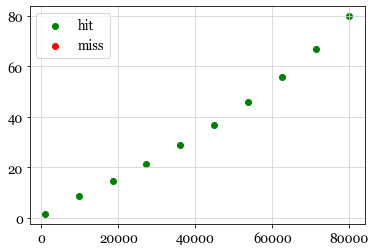

In [8]:
q = 180

fig = plt.figure(figsize=(6, 4))
plt.scatter(df[(df.q == q) & (df.hit == 1)].d, df[(df.q == q) & (df.hit == 1)].t, color='g', label='hit')
plt.scatter(df[(df.q == q) & (df.hit == 0)].d, df[(df.q == q) & (df.hit == 0)].t, color='r', label='miss')

plt.legend()
plt.grid(c='lightgray')
plt.show()

In [9]:
K = np.reshape(df.k.to_numpy(), (len(distances), len(heading_angles)))
        
interp = interpolate.interp2d(
    heading_angles,
    distances,
    K, 
    kind='linear'
)

<IPython.core.display.Javascript object>


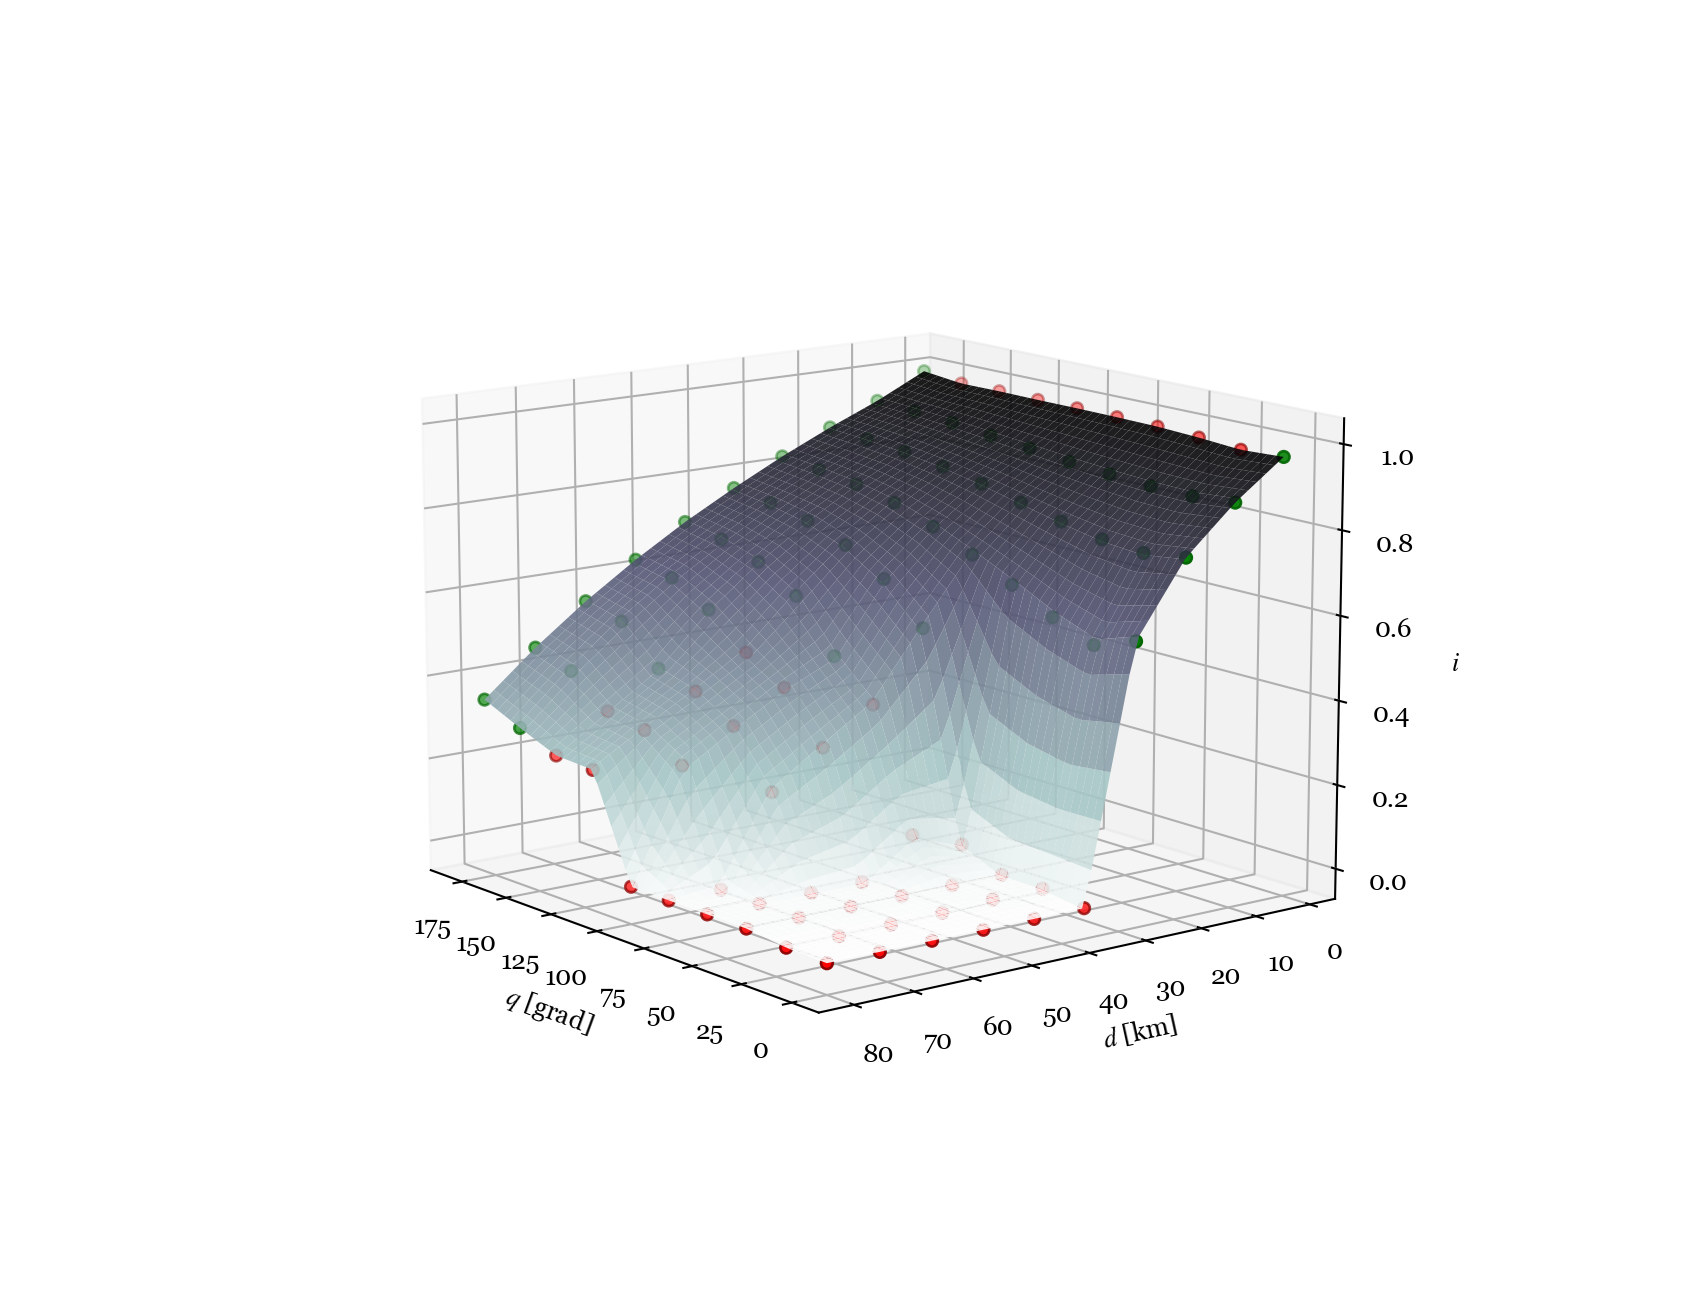

C:\Users\USER\AppData\Local\Temp\ipykernel_17672\351290637.py:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



In [47]:
%matplotlib notebook
fig = plt.figure(figsize=(9, 7), dpi=150)
ax = plt.axes(projection='3d')

ax.scatter(df[(df.hit == 1)].q, df[(df.hit == 1)].d, df[(df.hit == 1)].k, color='g', label='hit', edgecolor='darkgreen')
ax.scatter(df[(df.hit == 0)].q, df[(df.hit == 0)].d, df[(df.hit == 0)].k, color='r', label='miss', edgecolor='darkred')

y = np.linspace(min(df.d), max(df.d), 50)
x = np.linspace(min(df.q), max(df.q), 50)
X, Y = np.meshgrid(x, y)
Z = interp(x, y)

surf = ax.plot_surface(X, Y, Z, cmap=cm.bone_r, linewidth=2, alpha=0.9)
# fig.colorbar(surf, shrink=0.8, aspect=20)

ax.set(xlabel='$q$ [grad]', ylabel='$d$ [km]', zlabel='$i$')
ax.set_yticklabels([10, 0, 10, 20, 30 ,40, 50, 60, 70, 80, 90])

plt.show()

In [105]:
dump(interp, '../files/importance.pkl')

['../src/environments/importances.pkl']